In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## a) load/merge data and visualize logerror

In [2]:
# load data into DataFrames
df_train = pd.read_csv('train.csv')
df_prop = pd.read_csv('properties.csv')
df_merge = pd.merge(df_train, df_prop,on ='id')

In [3]:
# eliminate outliers
percent_range = np.percentile(df_merge.logerror, [1, 99]);
print(df_merge)
df_merge[(df_merge.logerror < percent_range[0])] = df_merge[(df_merge.logerror == percent_range[0])]
df_merge[(df_merge.logerror > percent_range[1])] = df_merge[(df_merge.logerror == percent_range[1])]

             id  logerror transactiondate  airconditioningtypeid  \
0      14366692   -0.1684          1/1/16                    NaN   
1      14739064   -0.0030          1/2/16                    NaN   
2      10854446    0.3825          1/3/16                    NaN   
3      11672170   -0.0161          1/3/16                    1.0   
4      12524288   -0.0419          1/3/16                    NaN   
...         ...       ...             ...                    ...   
31720  12756771    0.0658        12/30/16                    NaN   
31721  11295458   -0.0294        12/30/16                    1.0   
31722  11308315    0.0070        12/30/16                    1.0   
31723  11703478    0.0431        12/30/16                    NaN   
31724  12566293    0.4207        12/30/16                    NaN   

       architecturalstyletypeid  basementsqft  bathroomcnt  bedroomcnt  \
0                           NaN           NaN          3.5         4.0   
1                           NaN    

0       -0.1684
1       -0.0030
2        0.3825
3       -0.0161
4       -0.0419
          ...  
31720    0.0658
31721   -0.0294
31722    0.0070
31723    0.0431
31724    0.4207
Name: logerror, Length: 31725, dtype: float64


Text(0.5, 0, 'Samples')

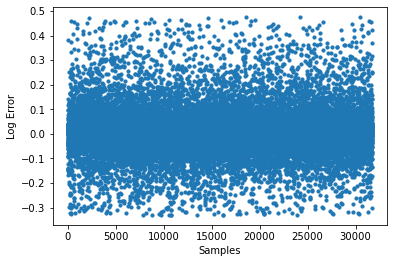

In [4]:
# scatter of logerr
print(df_merge.logerror)
x = np.arange(0,31725, 1)
plt.scatter(x, df_merge.logerror,s = 10)
plt.ylabel('Log Error')
plt.xlabel('Samples')

Text(0.5, 0, 'Log Error')

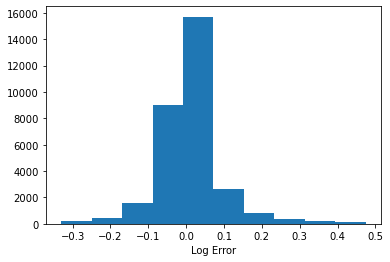

In [5]:
# histogram of logerr
plt.hist(df_merge.logerror)
plt.xlabel('Log Error')

## b) data cleaning

In [6]:
# build new data frame
missing_vals = df_merge.isna().sum()
col_num = df_merge.columns.transpose()
new_df = pd.DataFrame(list(zip(col_num, missing_vals)), columns = ["column_name", "missing_count"])

missing_ratio = df_merge.isna().sum() / len(df_merge)
new_df.insert(2, "missing_ratio", missing_ratio.values)

In [7]:
# fill missing data
df_merge = df_merge.fillna(df_merge.mean())

C:\Users\gandi\AppData\Local\Temp\ipykernel_27800\1960727304.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_merge = df_merge.fillna(df_merge.mean())


## c) univariate analysis

<AxesSubplot:>

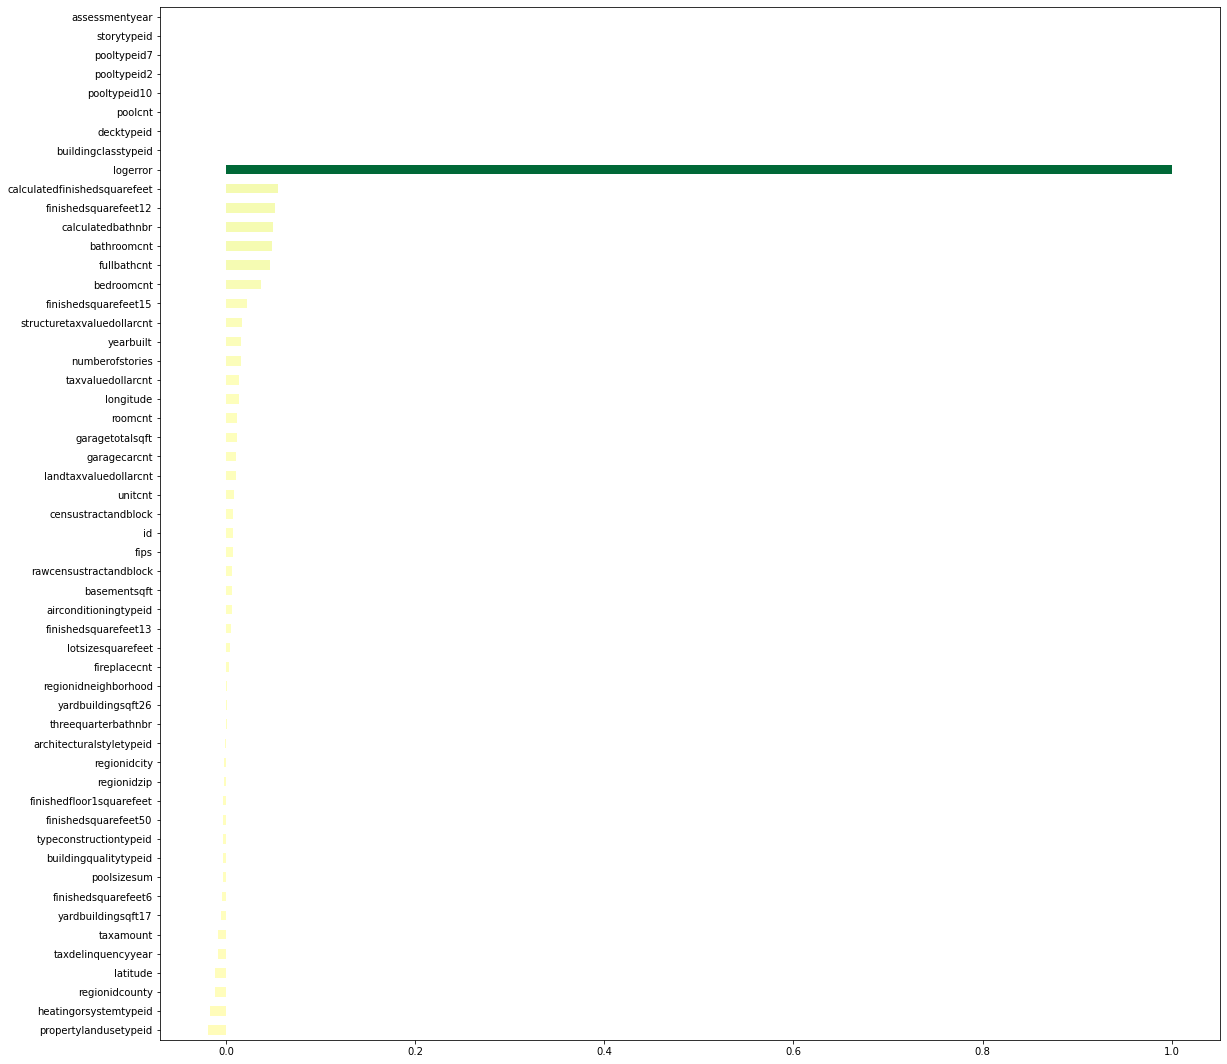

In [8]:
# make bar chart
corr_mat = df_merge.corrwith(df_merge["logerror"])
corr_mat = corr_mat.sort_values()

from matplotlib.colors import TwoSlopeNorm
fig, ax = plt.subplots(figsize =(19, 19))
norm = TwoSlopeNorm(vmin=-1, vcenter = 0, vmax=1)
colors = [plt.cm.RdYlGn(norm(c)) for c in corr_mat.values]
corr_mat.plot.barh(color=colors)

In [9]:
#Explain

#The reason behind why some of the values have no correlation values and become NaN is because the correlation equation
#has the standard deviation in the denominator. For these NaN cases, since the denominator becomes 0, the correlation 
#between the terms is NaN as a result of this division.

## d) non-linear regression model

In [10]:
non_lin_df = df_merge.drop(columns=['id', 'transactiondate',"hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"])

In [11]:
# split and train
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(non_lin_df, test_size = 0.3, shuffle = True)

x_train_stats = []
x_test_stats = []
for i in x_train.columns:
    x_train_stats.append([np.mean(x_train[i]), np.std(x_train[i])])
for i in x_test.columns:
    x_test_stats.append([np.mean(x_test[i]), np.std(x_test[i])])

count = 0;
for i in x_train.columns:
    stats = x_train_stats[count]
    if (stats[1] != 0): 
        x_train[i] = (x_train[i] - stats[0]) / stats[1]
    count +=1  
    
count = 0;
for i in x_test.columns:
    stats = x_test_stats[count]
    if (stats[1] != 0): 
        x_test[i] = (x_test[i] - stats[0]) / stats[1]
    count +=1  
from sklearn.neural_network import MLPRegressor as mlp
from sklearn.datasets import make_regression


x_train_new = x_train.drop(["logerror"], axis = 1)
reg = mlp(random_state = 1, max_iter = 500).fit(x_train_new, x_train.logerror)

x_test_new = x_test.drop(['logerror'], axis = 1)
pred = reg.predict(x_test_new)

In [12]:
# report importances and mse
from sklearn.metrics import mean_squared_error
x = mean_squared_error(x_test.logerror, pred)
print("Mean Squared Error: ", x)

Mean Squared Error:  1.1200822431414335
